In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import os
import datetime

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/road_sign_recognition'

/content/drive/My Drive/Colab Notebooks/matrix/road_sign_recognition


In [0]:
#get data
train= pd.read_pickle('ML_road_sign_recognition/data/train.p')
test= pd.read_pickle('ML_road_sign_recognition/data/test.p')

In [0]:
#create test and train sets
X_train,y_train=train['features'], train['labels']
X_test,y_test=train['features'], train['labels']

In [0]:
#change number of dimentions to be matching with number of sign names
if y_train.ndim==1:y_train=to_categorical(y_train)

In [0]:
if y_test.ndim==1:y_test=to_categorical(y_test)

In [0]:
y_test.shape

(34799, 43)

In [0]:
#get impoyt size na num classes for he train dataset
input_size=X_train.shape[1:]
num_clases=y_train.shape[1]

In [0]:
#function for creating model
def get_cnn_v1(input_size, num_clases):
  return Sequential([
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu', input_shape=input_size),
                    Flatten(),
                    Dense(num_clases,activation='softmax')

  ])

In [0]:
#training the model, preparation of the tensorboard_callback for the training visualisations
def train(model,X_train,y_train,params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  logdir=os.path.join('logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S') )
  tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
  
  model.fit(X_train,y_train,
            batch_size=params_fit.get('batch_size',128),
            epochs=params_fit.get('epochs',5),
            verbose=params_fit.get('verbose',1),
            validation_data=params_fit.get('validation_data',(X_train,y_train)),
            callbacks=[tensorboard_callback]
            )
  return model

In [0]:
model=get_cnn_v1(input_size, num_clases)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_trained=train(model,X_train,y_train)

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 55.1587 - accuracy: 0.7265 - val_loss: 0.2472 - val_accuracy: 0.9379
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2200 - accuracy: 0.9473 - val_loss: 0.1315 - val_accuracy: 0.9677
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1377 - accuracy: 0.9663 - val_loss: 0.1228 - val_accuracy: 0.9686
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1168 - accuracy: 0.9717 - val_loss: 0.1400 - val_accuracy: 0.9660
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0860 - accuracy: 0.9793 - val_loss: 0.0604 - val_accuracy: 0.9861


In [0]:
#predict y_test_prob (list of pobabilities for each sign ID) from test using the model above
y_test_prob=model_trained.predict(X_test)
y_test_prob

array([[1.20934529e-09, 5.64215441e-07, 5.65832536e-09, ...,
        1.20312834e-04, 9.99642611e-01, 1.33932308e-05],
       [3.07554058e-13, 4.28273905e-09, 7.82080178e-08, ...,
        1.09955076e-08, 9.96348321e-01, 6.75546119e-10],
       [4.64303524e-15, 4.80699508e-12, 7.58557162e-10, ...,
        2.70434231e-10, 9.99525547e-01, 6.49041845e-12],
       ...,
       [5.35874538e-34, 4.18005962e-17, 4.09787255e-21, ...,
        2.69688991e-20, 0.00000000e+00, 1.69369304e-29],
       [2.36919967e-26, 3.90406114e-20, 8.97851822e-19, ...,
        6.37619574e-21, 7.27423063e-30, 1.40119764e-30],
       [2.48055051e-31, 6.18395315e-19, 6.09792320e-23, ...,
        1.23881929e-18, 8.19716762e-32, 3.90225803e-32]], dtype=float32)

In [0]:
#checking data for sample sign
#create dictionary with sign labels - id: sign name
signs= pd.read_csv('ML_road_sign_recognition/data/signnames.csv')
dict_signs=signs.to_dict()['b']

# name of the sign y_test_prob[400] - argmax for checking which id has the highest probability
dict_signs[np.argmax(y_test_prob[400])]

'Wild animals crossing'

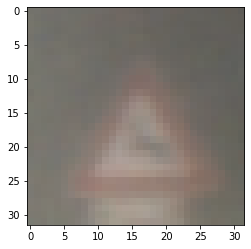

In [0]:
#display image
plt.imshow(X_test[400])

<BarContainer object of 43 artists>

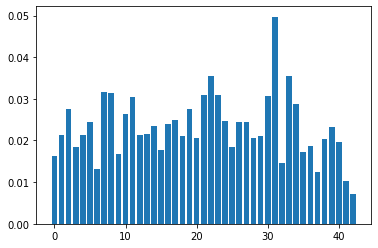

In [0]:
#probabiity distribution for y_test_prob[400]
plt.bar(range(43),y_test_prob[400] )

In [0]:
#for checking score
def predict_score(model_trained, X_test, y_test,scoring=accuracy_score):
  y_test_norm=np.argmax(y_test, axis=1)
  y_test_prob=model_trained.predict(X_test)
  y_pred=np.argmax(y_test_prob,axis=1)

  return scoring(y_test_norm,y_pred)


In [0]:
predict_score(model_trained, X_test, y_test)

0.9861202908129544

In [0]:
#2nd function for creating model
def get_cnn_v2(input_size, num_clases):
  return Sequential([
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=input_size),
                    MaxPool2D(),
                    Dropout(0.3),
                     
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),
                     
                    Flatten(),
                    
                    Dense(1024,activation='relu'),
                    Dropout(0.5),
                     
                    Dense(num_clases,activation='softmax')

  ])



In [0]:
#combine train and predict
def train_predict(my_model):
  model_trained=train(my_model,X_train,y_train)
  return predict_score(model_trained, X_test, y_test)



ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
train_predict(get_cnn_v2(input_size, num_clases))


Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 6.1070 - accuracy: 0.1808 - val_loss: 2.1267 - val_accuracy: 0.4273
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 1.9261 - accuracy: 0.4519 - val_loss: 1.1071 - val_accuracy: 0.6737
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 1.2699 - accuracy: 0.6217 - val_loss: 0.6864 - val_accuracy: 0.8452
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.8668 - accuracy: 0.7374 - val_loss: 0.3279 - val_accuracy: 0.9153
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.6195 - accuracy: 0.8117 - val_loss: 0.2056 - val_accuracy: 0.9561


0.9561194287192161

In [0]:
#additional layers
def get_cnn_v3(input_size, num_clases):
  return Sequential([
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=input_size),
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.5),
                    
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),
                     
                    Flatten(),
                    
                    Dense(1024,activation='relu'),
                    Dropout(0.5),
                     
                    Dense(num_clases,activation='softmax')

  ])

train_predict(get_cnn_v3(input_size, num_clases))

Epoch 1/5
272/272 [==============================] - 10s 37ms/step - loss: 2.4524 - accuracy: 0.4057 - val_loss: 0.7989 - val_accuracy: 0.8048
Epoch 2/5
272/272 [==============================] - 10s 36ms/step - loss: 0.7066 - accuracy: 0.7787 - val_loss: 0.1930 - val_accuracy: 0.9528
Epoch 3/5
272/272 [==============================] - 10s 36ms/step - loss: 0.3818 - accuracy: 0.8811 - val_loss: 0.0809 - val_accuracy: 0.9778
Epoch 4/5
272/272 [==============================] - 10s 36ms/step - loss: 0.2612 - accuracy: 0.9193 - val_loss: 0.0503 - val_accuracy: 0.9871
Epoch 5/5
272/272 [==============================] - 10s 36ms/step - loss: 0.2070 - accuracy: 0.9349 - val_loss: 0.0519 - val_accuracy: 0.9895


0.9895399293083135

In [0]:
#additional layers
def get_cnn_v4(input_size, num_clases):
  return Sequential([
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=input_size),
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu',padding='same'),
                    MaxPool2D(),
                    Dropout(0.3),
                    
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'),
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),
                    
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'),
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),


                    Flatten(),
                    
                    Dense(1024,activation='relu'),
                    Dropout(0.3),
                     
                    Dense(num_clases,activation='softmax')

  ])

train_predict(get_cnn_v4(input_size, num_clases))

Epoch 1/5
272/272 [==============================] - 12s 44ms/step - loss: 2.5696 - accuracy: 0.3186 - val_loss: 0.7671 - val_accuracy: 0.7634
Epoch 2/5
272/272 [==============================] - 12s 43ms/step - loss: 0.7907 - accuracy: 0.7589 - val_loss: 0.1884 - val_accuracy: 0.9508
Epoch 3/5
272/272 [==============================] - 12s 43ms/step - loss: 0.3716 - accuracy: 0.8867 - val_loss: 0.0921 - val_accuracy: 0.9752
Epoch 4/5
272/272 [==============================] - 12s 43ms/step - loss: 0.2488 - accuracy: 0.9247 - val_loss: 0.0626 - val_accuracy: 0.9834
Epoch 5/5
272/272 [==============================] - 12s 43ms/step - loss: 0.1853 - accuracy: 0.9434 - val_loss: 0.0368 - val_accuracy: 0.9905


0.9904594959625277

In [0]:
#additional layers
def get_cnn_v5(input_size, num_clases):
  return Sequential([
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=input_size),
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu',padding='same'),
                    MaxPool2D(),
                    Dropout(0.3),
                    
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'),
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),
                    
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'),
                    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),


                    Flatten(),
                    
                    Dense(1024,activation='relu'),
                    Dropout(0.3),
                     
                    Dense(1024,activation='relu'),
                    Dropout(0.3),
                     
                    Dense(num_clases,activation='softmax')

  ])

train_predict(get_cnn_v5(input_size, num_clases))

Epoch 1/5
272/272 [==============================] - 13s 46ms/step - loss: 2.6612 - accuracy: 0.2696 - val_loss: 1.2638 - val_accuracy: 0.5927
Epoch 2/5
272/272 [==============================] - 12s 45ms/step - loss: 1.0610 - accuracy: 0.6481 - val_loss: 0.3439 - val_accuracy: 0.8786
Epoch 3/5
272/272 [==============================] - 12s 45ms/step - loss: 0.4938 - accuracy: 0.8387 - val_loss: 0.1236 - val_accuracy: 0.9657
Epoch 4/5
272/272 [==============================] - 12s 45ms/step - loss: 0.3246 - accuracy: 0.8988 - val_loss: 0.0589 - val_accuracy: 0.9832
Epoch 5/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2303 - accuracy: 0.9305 - val_loss: 0.0628 - val_accuracy: 0.9815


0.9815224575418834

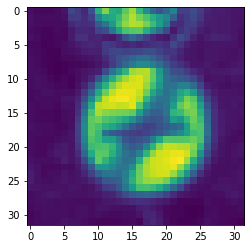

In [0]:
# reducing colors into 1
plt.imshow(color.rgb2gray(X_train[0]))

In [0]:
#preparing new gray datasets and reshaping into (X,32,32,1) instead of (X,32,32) - we need it for traiing
X_train_gray=color.rgb2gray(X_train).reshape(-1,32,32,1)
X_test_gray=color.rgb2gray(X_test).reshape(-1,32,32,1)

print(X_test_gray.shape,X_test_gray.shape)

(34799, 32, 32, 1) (34799, 32, 32, 1)


In [0]:
model=get_cnn_v5((32,32,1), num_clases)


model_trained=train(model,X_train_gray,y_train,params_fit={})

predict_score(model_trained, X_test_gray, y_test,scoring=accuracy_score)

Epoch 1/5
272/272 [==============================] - 12s 46ms/step - loss: 2.3380 - accuracy: 0.3337 - val_loss: 0.6640 - val_accuracy: 0.7764
Epoch 2/5
272/272 [==============================] - 12s 45ms/step - loss: 0.5412 - accuracy: 0.8278 - val_loss: 0.1370 - val_accuracy: 0.9578
Epoch 3/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2374 - accuracy: 0.9253 - val_loss: 0.0749 - val_accuracy: 0.9811
Epoch 4/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1544 - accuracy: 0.9517 - val_loss: 0.0318 - val_accuracy: 0.9918
Epoch 5/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1221 - accuracy: 0.9634 - val_loss: 0.0253 - val_accuracy: 0.9934


0.9933906146728354